>IMPORTING NECESSARY LIBRARIES FOR TRAINING OF MODEL

In [7]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

# Load data using a Keras utility


In [8]:
# directory_path
data_dir = "Potato"

# Define some parameters for the loader:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

#It's good practice to use a validation split when developing your model.
#You will use 80% of the images for training and 20% for validation.
train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
#     validation_split=0.2,
#     subset="training",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

print(len(train))
# val = tf.keras.preprocessing.image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     shuffle=True,
#     image_size=(256, 256),
#     batch_size=batch_size)

Found 2152 files belonging to 3 classes.
68


In [9]:
#manually iterate over the dataset and retrieve batches of images:
for image_batch, labels_batch in train.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32,)


In [10]:
#You can find the class names in the class_names attribute on these datasets.
class_names=train.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Visualize the data

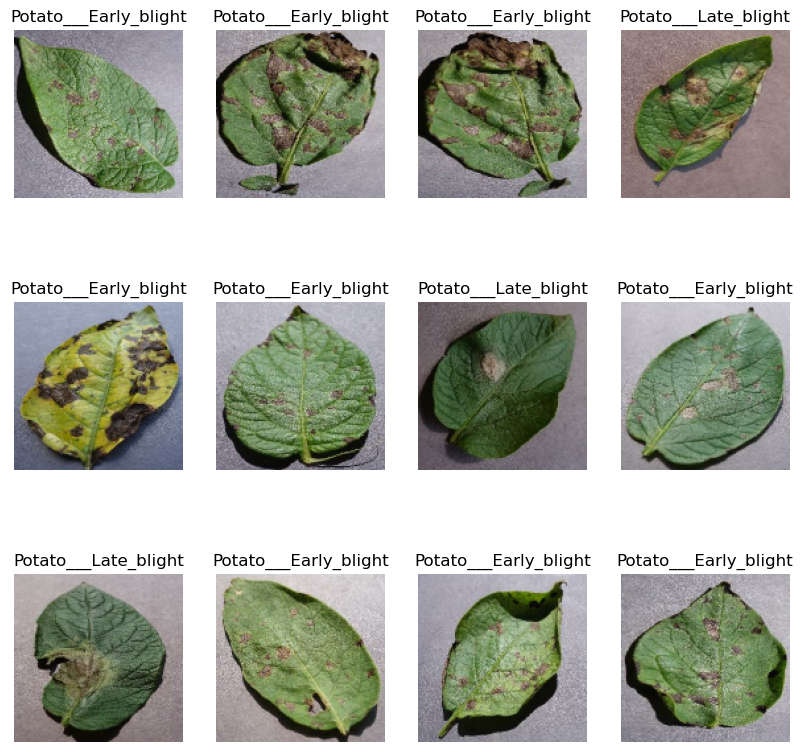

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in train.take(1):
    for i in range(12):
        ax=plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [14]:
# Splitting the Daaset into Training, Validation and Testing
train=train.take(int(0.8*len(train)))
valid=train.skip(int(0.8*len(train))).take(int(0.1*len(train)))
test=train.skip(int(0.8*len(train))).skip(int(0.1*len(train)))

In [15]:
len(train),len(valid),len(test)

(43, 4, 5)

In [27]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
     print("Failed to detect a GPU.")

Failed to detect a GPU.


#  Standardize the data

In [28]:
#The RGB channel values are in the [0, 255] range.
# normalization_layer = tf.keras.layers.Rescaling(1./255)

In [29]:
# normalized_dataset = train.map(lambda x, y: (normalization_layer(x), y))
# normalized_val_dataset = valid.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_dataset))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

# Configure the dataset for performance

In [30]:
AUTOTUNE = tf.data.AUTOTUNE
train= train.cache().prefetch(buffer_size=AUTOTUNE)
valid = valid.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
 for image_batch, labels_batch in test.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 128, 128, 3)
[1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 2 0 0 0 2 1 1 1 0 0 1 0 0 1 1 0]


In [32]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [33]:
data_augumentation= tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
#     layers.RandomTranslation(height_factor=0.2, width_factor=0.2, )
])

In [34]:
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 3

# model = models.Sequential([
#     resize_and_rescale,
#     data_augumentation,
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),
# ])

# model.build(input_shape=input_shape)


# CNN Model architecture

num_classes = 3

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    resize_and_rescale,
    data_augumentation,

    tf.keras.layers.Conv2D(8, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 63, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 319,955 (1.22 MB)

 Trainable params: 319,955 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Model compilation
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

# Early stopping to avoid overfitting
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      min_delta=0.0001,
                                                      patience=10)


In [36]:
# training the model
history= model.fit(train, epochs=50, batch_size=32, validation_data=valid)  #callbacks=[earlystop_callback]

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.4388 - loss: 0.9623 - val_accuracy: 0.5312 - val_loss: 0.8286
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.6039 - loss: 0.8341 - val_accuracy: 0.8203 - val_loss: 0.4615
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.7830 - loss: 0.5665 - val_accuracy: 0.9062 - val_loss: 0.2632
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.8310 - loss: 0.4182 - val_accuracy: 0.8828 - val_loss: 0.2842
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.8525 - loss: 0.3828 - val_accuracy: 0.9375 - val_loss: 0.2128
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.8839 - loss: 0.3253 - val_accuracy: 0.9375 - val_loss: 0.2114
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9007 - loss: 0.2886 - val_accuracy: 0.9375 - val_loss: 0.1581
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.8920 - loss: 0.2983 - val_accuracy: 0

In [37]:
scores = model.evaluate(test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9796 - loss: 0.0865


In [57]:
# Let's save our model 
model.save("final_model_99%.keras")
import pickle
# filename = './finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))

TypeError: cannot pickle 'module' object

In [46]:
model = tf.keras.models.load_model('final_model.keras')

ValueError: File not found: filepath=final_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
def predict(img):
    img_array = img.reshape(-1,128,128,3)
    #img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)[0]

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return {class_names[i]: float(predictions[i]) for i in range(3)}


# Model Evaluation

>**Training history**

In [ ]:
#Let’s look at Loss and Accuracy of the model at each epoch of training.
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss plots
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

>**Confusion matrix**

In [ ]:
#By visualizing the confusion matrix, an individual could determine the accuracy of the model by observing the diagonal values 
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in valid:  
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

# Confusion matrix
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')

sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)

plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)

plt.show()

>**Classification report**

In [ ]:
print(classification_report(correct_labels, predicted_labels))

In [ ]:
# !pip install gradio

In [ ]:
# import gradio as gr
# from PIL import Image
# #create a function to make predictions
# #return a dictionary of labels and probabilities
# model = tf.keras.models.load_model('final_model.keras')
# class_names =['Potato___Early_blight','Potato___Late_blight','Potato___healthy']

# def predict(img):
#     img_array = img.reshape(-1,128,128,3)

#     predictions = model.predict(img_array)[0]

# #     predicted_class = class_names[np.argmax(predictions[0])]
# #     confidence = round(100 * (np.max(predictions[0])), 2)
#     return {class_names[i]: float(predictions[i]) for i in range(3)}

# gr.Interface(fn=predict, inputs=gr.Image(), outputs=gr.Label(num_top_classes=3)).launch(debug='True',share=True,theme=gr.themes.Soft())

# Now Uisng The Model Resnet50